# Setup Enviornment

Linux\Unix\Mac
```bash
python3 -m venv .venv
source .venv/bin/activate
python3 -m pip install -r requirements.txt
```
Windows
```bash
python3 -m venv .venv
.venv\Scripts\activate
python3 -m pip install -r requirements.txt
```

Using device NVIDIA T600
30


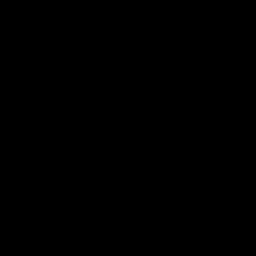

In [4]:
import compushady.config
import compushady.formats
import compushady
from compushady.shaders import hlsl
import struct
import platform
import math
from PIL import Image
from IPython.display import Image as IPy_Image

import os
#import sys
import pathlib

compushady.config.set_debug(True)

print('Using device', compushady.get_current_device().name)

target = compushady.Texture2D(256, 256, compushady.formats.R8G8B8A8_UNORM)

buffer = compushady.Buffer(target.size, compushady.HEAP_READBACK)

# use 16 to make d3d11 happy...
config = compushady.Buffer(16, compushady.HEAP_UPLOAD)

config_fast = compushady.Buffer(config.size)

shader = hlsl.compile("""
cbuffer Config : register(b0)
{
    float multiplier;
};

RWTexture2D<float4> target : register(u0);

float mandlebrot(float2 xy)
{
    const uint max_iterations = 100;
    xy = (xy - 0.5) * 2 - float2(1, 0);
    float2 z = float2(0, 0);
    for(uint i = 0; i < max_iterations; i++)
    {
        z = float2(z.x * z.x - z.y * z.y, z.x * z.y * 2) + xy;
        if (length(z) > multiplier * 2) return float(i) / max_iterations;
    }

    return 1; // white
 }

[numthreads(8,8,1)]
void main(int3 tid : SV_DispatchThreadID)
{
    uint width;
    uint height;
    target.GetDimensions(width, height);
    float2 xy = tid.xy / float2(width, height);
    float m = mandlebrot(xy);
    target[tid.xy] = float4(m, 0, multiplier, 1);
}
""")

compute = compushady.Compute(shader, cbv=[config_fast], uav=[target])

multiplier = 0

images = []

for i in range(0, 30):
    config.upload(struct.pack('f', abs(math.sin(multiplier))))
    config.copy_to(config_fast)
    compute.dispatch(target.width // 8, target.height // 8, 1)
    target.copy_to(buffer)
    image = Image.new('RGBA', (target.width, target.height))
    image.frombytes(buffer.readback())
    images.append(image)
    multiplier += 0.1

print(len(images))
img_out_dir = os.path.join(pathlib.Path().resolve(),'img_output')
os.makedirs(img_out_dir, exist_ok=True)
img_path =  os.path.join(img_out_dir,'compushady_mandlebrot.gif')
images[0].save(img_path,
               save_all=True, append_images=images[1:], optimize=False, duration=150, loop=0)
IPy_Image(filename=img_path)